# Generate input files for MOM6
Each cell corresponds to a different component of the initialization  
This includes grid, sponge, TS, wind forcing, buoyancy forcing  
Save netcdf files to the INPUT file of the configuration, with a simulation-specific name

In [2]:
import numpy as np
import xarray as xr
from matplotlib import pyplot as plt

rootdir = '/Users/hemantkhatri/Documents/Acads/GFDL/Github_scripts/GFDL_Graeme/channel'
config = 'Idealised_SO'
simulation = '4th-deg'

# Grid
Define the parameters of the grid  
Output the vertical and horizontal coordinate, and a 2D mesh of the horizontal coordinates  

In [2]:
# ___ HORIZONTAL GRID ___#
# Specify geometry of horizontal grid and it MUST BE CONSISTENT WITH THE MODEL GRID
# Latitude and longitude
SOUTHLAT, LENLAT = (-70.0, 50.0)
WESTLON, LENLON = (0.0, 80.0)

MAXIMUM_DEPTH, MINIMUM_DEPTH = (4000., 0.)

# Number of grid cells
NI, NJ = (int(LENLON*4), int(LENLAT*4))

# Grid point positions (tracer point)
X = np.linspace(WESTLON,WESTLON+LENLON,NI+1)
X1d = (X[1:] + X[:-1]) / 2
Y = np.linspace(SOUTHLAT,SOUTHLAT+LENLAT,NJ+1)
Y1d = (Y[1:] + Y[:-1]) / 2
X,Y = np.meshgrid(X1d,Y1d)

# Define lat and lon dimensions set to zero at the midpoint
X0 = xr.DataArray(np.linspace(-NI/2,NI/2,NI),coords=[X1d],dims='lon')
Y0 = xr.DataArray(np.linspace(-NJ/2,NJ/2,NJ),coords=[Y1d],dims='lat')
# Define xarray data array with dimensions of horizontal grid
# (for broadcasting dimensions of other variables later in the notebook)
hgrid = xr.DataArray(np.ones([NI,NJ]),coords=[X1d,Y1d],dims=['lon','lat'])


# Defile Topography
Includes a shelf ridge on the southern boundary and elongated ridge structure in the middle of the domain smoothly decaying to zero at some points.

In [3]:
def create_shelf(H, Hs, Y1, Ys, Ws):
    # H = max depth, Hs = shelf depth, Y1 = lat, Ys = shelf latitude, Ws = shelf width
    depth_shelf = 0.5*(H - Hs)*(1 - np.tanh((Y1 - Ys)/Ws))
    
    return depth_shelf

def create_ridge_bump(Hs, X1, Xs, Y1, Ys, W1s, W2s):
    # H = max depth, Hs = ridge depth, X1 = lon, Y1 = lat, Xs, Ys = shelf lan and lat, W1s, W2s = ridge length and width
    bump_X = np.exp(-((X1 - Xs)/W1s)**2)
    bump_Y = np.exp(-((Y1 - Ys)/W2s)**2)
    depth_bump = Hs*bump_X*bump_Y
    
    return depth_bump
    
depth = MAXIMUM_DEPTH*hgrid

min_shelf_depth, shelf_lat, shelf_width = (500., -60., 3.0)
d_shelf = create_shelf(MAXIMUM_DEPTH, min_shelf_depth, hgrid.lat, shelf_lat, shelf_width)

max_bump_height, bump_lon, bump_lat = (3000., 20., -40)
bump_width_X, bump_width_Y = (10., 10.)

d_bump = create_ridge_bump(max_bump_height, hgrid.lon, bump_lon, hgrid.lat, bump_lat, bump_width_X, bump_width_Y)

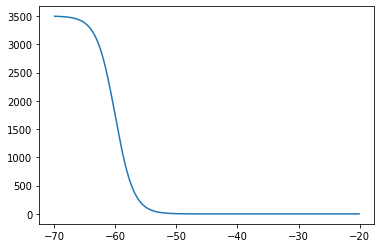

In [4]:
#hgrid.lat
plt.plot(hgrid.lat, d_shelf)

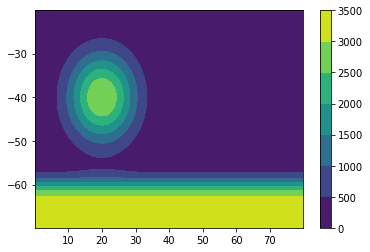

In [5]:
plt.contourf(hgrid.lon, hgrid.lat, (d_bump + d_shelf).transpose())
plt.colorbar()

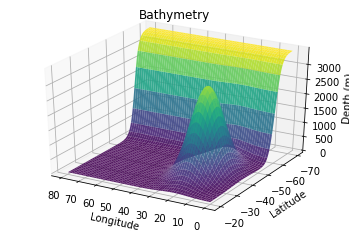

In [49]:
#from mpl_toolkits import mplot3d
#import seaborn as sns

fig = plt.figure()
ax = plt.axes(projection='3d')
ax.plot_surface(X, Y, (d_bump + d_shelf).transpose(), cmap='viridis', rstride = 5, cstride= 5, 
                alpha=0.9, linestyles="None")
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.set_zlabel('Depth (m)')
ax.set_title('Bathymetry')
ax.view_init(30, 120)

In [10]:
X.shape

(200, 320)

# Read grid information from MOM6 ocean_geometry.nc and generate topography using that.

In [3]:
rootdir = '/Users/hemantkhatri/Documents/Acads/GFDL/Github_scripts/GFDL_Graeme/channel/4th_deg'

mom_geo = xr.open_dataset(rootdir + '/ocean_geometry.nc') 

In [4]:
mom_geo

<xarray.Dataset>
Dimensions:  (lath: 160, latq: 160, lonh: 240, lonq: 240)
Coordinates:
  * lath     (lath) float64 -54.27 -54.13 -53.98 -53.83 ... -24.81 -24.58 -24.36
  * lonh     (lonh) float64 0.125 0.375 0.625 0.875 ... 59.12 59.37 59.62 59.87
  * latq     (latq) float64 -54.2 -54.05 -53.91 -53.76 ... -24.7 -24.47 -24.24
  * lonq     (lonq) float64 0.25 0.5 0.75 1.0 1.25 ... 59.25 59.5 59.75 60.0
Data variables:
    geolatb  (latq, lonq) float64 ...
    geolonb  (latq, lonq) float64 ...
    geolat   (lath, lonh) float64 ...
    geolon   (lath, lonh) float64 ...
    D        (lath, lonh) float64 ...
    f        (latq, lonq) float64 ...
    dxCv     (latq, lonh) float64 ...
    dyCu     (lath, lonq) float64 ...
    dxCu     (lath, lonq) float64 ...
    dyCv     (latq, lonh) float64 ...
    dxT      (lath, lonh) float64 ...
    dyT      (lath, lonh) float64 ...
    dxBu     (latq, lonq) float64 ...
    dyBu     (latq, lonq) float64 ...
    Ah       (lath, lonh) float64 ...
    Aq   

Text(0, 0.5, 'Lat')

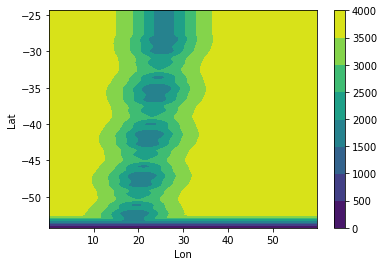

In [7]:
plt.contourf(mom_geo['lonh'], mom_geo['lath'], mom_geo['D'])
plt.colorbar()
plt.xlabel('Lon')
plt.ylabel('Lat')

Text(0, 0.5, 'Lat')

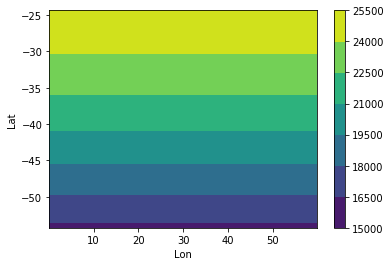

In [10]:
plt.contourf(mom_geo['lonh'], mom_geo['lath'], mom_geo['dxT'])
plt.colorbar()
plt.xlabel('Lon')
plt.ylabel('Lat')

In [16]:
mom_geo.dxCv

<xarray.DataArray 'dxCv' (latq: 160, lonh: 240)>
array([[16279.337614, 16279.337614, 16279.337614, ..., 16279.337614,
        16279.337614, 16279.337614],
       [16336.997107, 16336.997107, 16336.997107, ..., 16336.997107,
        16336.997107, 16336.997107],
       [16394.753255, 16394.753255, 16394.753255, ..., 16394.753255,
        16394.753255, 16394.753255],
       ...,
       [25283.611002, 25283.611002, 25283.611002, ..., 25283.611002,
        25283.611002, 25283.611002],
       [25329.548912, 25329.548912, 25329.548912, ..., 25329.548912,
        25329.548912, 25329.548912],
       [25375.170068, 25375.170068, 25375.170068, ..., 25375.170068,
        25375.170068, 25375.170068]])
Coordinates:
  * lonh     (lonh) float64 0.125 0.375 0.625 0.875 ... 59.12 59.37 59.62 59.87
  * latq     (latq) float64 -54.2 -54.05 -53.91 -53.76 ... -24.7 -24.47 -24.24
Attributes:
    long_name:  Zonal grid spacing at v points
    units:      m

In [5]:
def create_shelf(H, Hs, Y1, Ys, Ws):
    # H = max depth, Hs = shelf depth, Y1 = lat, Ys = shelf latitude, Ws = shelf width
    depth_shelf = 0.5*(H - Hs)*(1 - np.tanh((Y1 - Ys)/Ws))
    
    return depth_shelf

def create_2D_guassian_ridge(Hs, X1, Xs, Y1, Ys, Wx, Wy, theta):
    # Hs = ridge height, X1 = lon, Y1 = lat, Xs, Ys = shelf lan and lat, Wx, Wy = ridge length and width
    # ridge rotation
    
    a = np.cos(theta)**2/(2*Wx**2) + np.sin(theta)**2/(2*Wy**2);
    b = -np.sin(2*theta)/(4*Wx**2) + np.sin(2*theta)/(4*Wy**2);
    c = np.sin(theta)**2/(2*Wx**2) + np.cos(theta)**2/(2*Wy**2);

    Z = Hs*np.exp( - (a*(X1-Xs)**2 + 2*b*(X1-Xs)*(Y1-Ys) + c*(Y1-Ys)**2));
    
    return Z

def create_rectangular_bump(Hs, X1, Xs, Y1, Ys, Wx, Wy, dx, dy):
    # Hs = max depth X1 = lon, Y1 = lat, Xs, Ys = bump lan and lat, Wx, Wy = bump length and width
    # dx, dy = controls the rate of bump heigh decay
    x = (X1 - Xs)/Wx
    y = (Y1 - Ys)/Wy
    z = np.exp(-dx/(1 - x**2) - dy/(1 - y**2))
    
    z[(np.abs(x) >= 1.) | (np.abs(y) >= 1.)] = 0.
    
    z = z*Hs/np.max(z)
    
    return z

In [6]:
MAXIMUM_DEPTH, MINIMUM_DEPTH = (4000., 0.)

lat = mom_geo['geolat'].values
lon = mom_geo['geolon'].values

X = mom_geo['dxT'].cumsum(dim='lonh') 
Y = mom_geo['dyT'].cumsum(dim='lath')

X = X - X.mean(dim='lonh')

In [7]:
lat = Y.values;
lon = X.values;

Text(0, 0.5, 'Latitude')

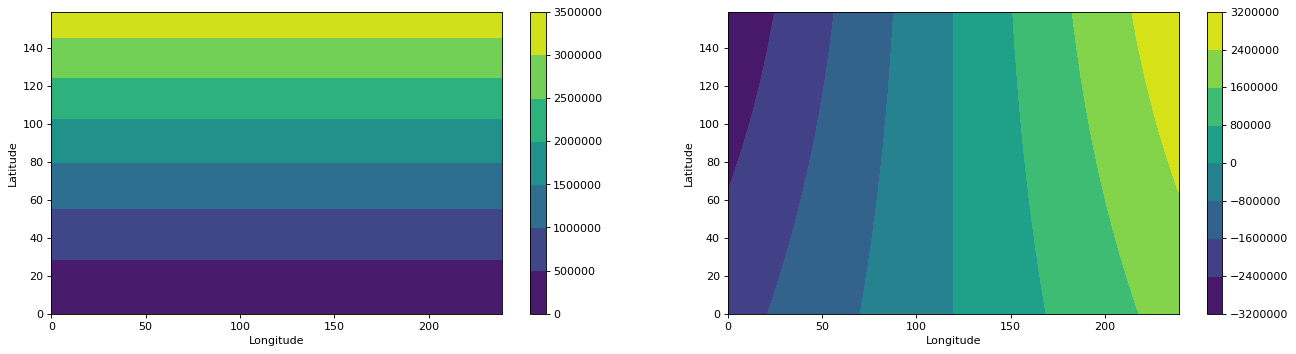

In [8]:
plt.figure(num=None, figsize=(20, 5), dpi=80, facecolor='w', edgecolor='k')

plt.subplot(1,2,1)
plt.contourf(lat)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.colorbar()

plt.subplot(1,2,2)
plt.contourf(lon)
plt.colorbar()
plt.xlabel('Longitude')
plt.ylabel('Latitude')

In [25]:
min_shelf_depth, shelf_lat, shelf_width = (500., 500000., 100000.)
#min_shelf_depth, shelf_lat, shelf_width = (500., -48., 2.0)
d_shelf = create_shelf(MAXIMUM_DEPTH, min_shelf_depth, lat, shelf_lat, shelf_width)

ridge_depth, ridge_lon, ridge_lat, ridge_width_x, ridge_width_y = (3000., -1000000., 2000000., 500000., 5000000.)
#ridge_depth, ridge_lon, ridge_lat, ridge_width_x, ridge_width_y = (3000., 20., -35., 5.0, 50.)
theta = -30.*np.pi/180
d_ridge = create_2D_guassian_ridge(ridge_depth, lon, ridge_lon, lat, ridge_lat, ridge_width_x, ridge_width_y, theta)

bump_depth, bump_lon, bump_lat, bump_width_x, bump_width_y = (1., -1000000., 2000000., 1000000.0, 1000000.)
#bump_depth, bump_lon, bump_lat, bump_width_x, bump_width_y = (1., 20., -40., 20.0, 15.)
bump_decay_x, bump_decay_y = (1., 1.)
d_bump = create_rectangular_bump(bump_depth, lon, bump_lon, lat, bump_lat, bump_width_x, bump_width_y, 
                                 bump_decay_x, bump_decay_y)

#height = np.maximum(d_shelf, d_ridge*d_bump) 
height = np.maximum(d_shelf, d_bump*3000.) 

/Users/hemantkhatri/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: overflow encountered in exp


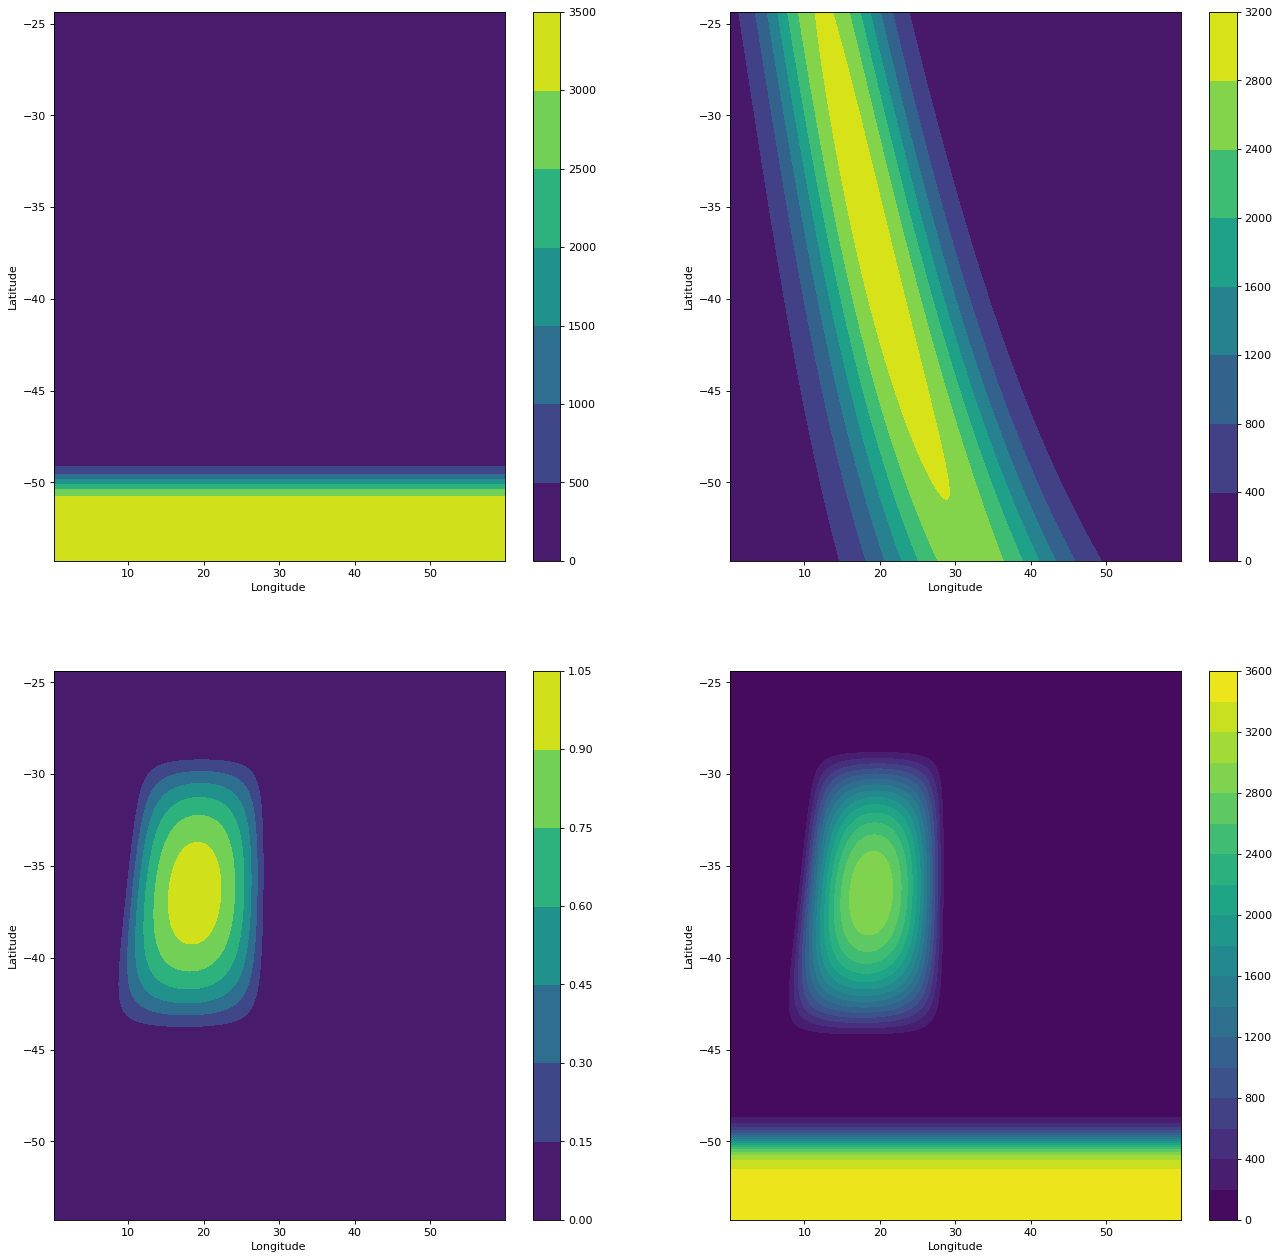

In [26]:
plt.figure(num=None, figsize=(20, 20), dpi=80, facecolor='w', edgecolor='k')

plt.subplot(2,2,1)
plt.contourf(mom_geo['lonh'], mom_geo['lath'], d_shelf)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.colorbar()

plt.subplot(2,2,2)
plt.contourf(mom_geo['lonh'], mom_geo['lath'], d_ridge)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.colorbar()

plt.subplot(2,2,3)
plt.contourf(mom_geo['lonh'], mom_geo['lath'], d_bump)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.colorbar()

plt.subplot(2,2,4)
plt.contourf(mom_geo['lonh'], mom_geo['lath'], height, 20)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.colorbar()

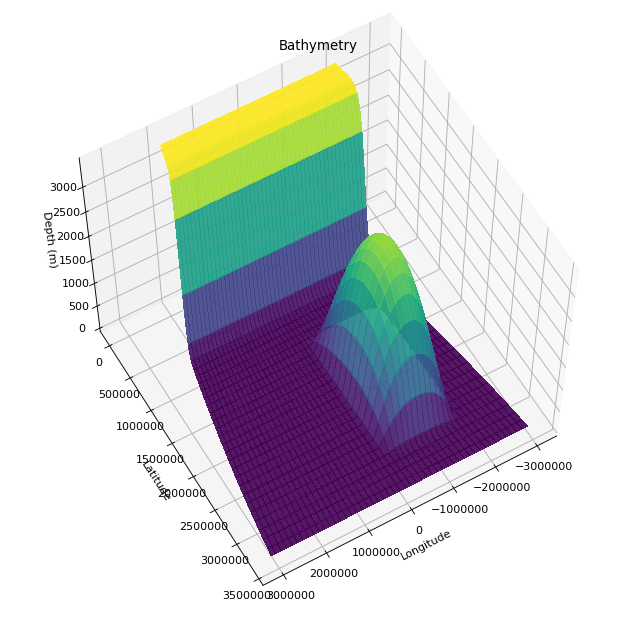

In [29]:
from mpl_toolkits import mplot3d
from matplotlib.colors import LightSource

plt.figure(num=None, figsize=(10, 10), dpi=80, facecolor='w', edgecolor='k')

ax = plt.axes(projection='3d')
surf = ax.plot_surface(lon, lat, height, cmap='viridis', rstride = 5, cstride= 5, linewidth=0,
                antialiased=False, alpha=0.9, linestyles="None")
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.set_zlabel('Depth (m)')
ax.set_title('Bathymetry')
ax.view_init(60, 60)

ls = LightSource(azdeg=120, altdeg=65)

In [33]:
# Save data to nc file
ds = xr.Dataset(
        data_vars={'depth':    (('lat', 'lon'), height)},
        coords={'lat': mom_geo['lath'].values, 'lon': mom_geo['lonh'].values})

ds.lat.attrs['units'] = 'Deg'
ds.lon.attrs['units'] = 'Deg'
ds.depth.attrs['units'] = 'm'

ds.lon.attrs['standard_name'] = 'Longitude'
ds.lat.attrs['standard_name'] = 'Latitude'
ds.depth.attrs['standard_name'] = 'Total Depth'

ds.to_netcdf(rootdir+'/depth.nc')

In [ ]:
mom_geo.close()